In [21]:
import numpy as np
import pandas as pd

import os
import sys
import random

import collections

import matplotlib.pyplot as plt

import cv2

from keras.models import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from keras import backend as K
from keras.layers import Lambda
from keras.models import Model, load_model
from keras.optimizers import Adam

import math
import utils

In [4]:
face_cascades = cv2.CascadeClassifier('../../packtpub/NeuralNetworkProjectsWIthPython/Chapter07/haarcascade_frontalface_default.xml')

In [8]:
def detect_faces(img, draw_box=True):
    # convert image to grayscale
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # detect faces
    faces = face_cascades.detectMultiScale(grayscale_img, scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv2.CASCADE_SCALE_IMAGE)
    
    face_box, face_coords = None, []

    for (x, y, w, h) in faces:
        if draw_box:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 5)
        face_box = img[y:y+h, x:x+w]
        face_coords = [x,y,w,h]

    return img, face_box, face_coords


In [8]:
files = os.listdir('../../packtpub/NeuralNetworkProjectsWIthPython/Chapter07/sample_faces/')
images = [file for file in files if 'jpg' in file]
for image in images:
    img = cv2.imread('../../packtpub/NeuralNetworkProjectsWIthPython/Chapter07/sample_faces/' + image)
    detected_faces, _, _ = detect_faces(img)
    cv2.imwrite('../../packtpub/NeuralNetworkProjectsWIthPython/Chapter07/sample_faces/detected_faces_2/' + image, detected_faces)

In [5]:
from keras_preprocessing.image import load_img, img_to_array 

In [15]:
# Iterate through the list of subfolders (subjects)
# Idx is the subject ID

def get_data(dir):
    X_train, Y_train = [], []
    X_test, Y_test = [], []
    
    # Get list of subfolders from faces_dir
    # Each subfolder contains images from one subject
    subfolders = sorted([file.path for file in os.scandir(dir) if file.is_dir()])
    for idx, folder in enumerate(subfolders):
        for file in sorted(os.listdir(folder)):
            img = load_img(folder+"/"+file, color_mode='grayscale')
            img = img_to_array(img).astype('float32')/255
            img = img.reshape(img.shape[0], img.shape[1],1)
            if idx < 35:
                X_train.append(img)
                Y_train.append(idx)
            else:
                X_test.append(img)
                Y_test.append(idx-35)

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    return (X_train, Y_train), (X_test, Y_test)

In [7]:
faces_dir = '../../packtpub/NeuralNetworkProjectsWIthPython/Chapter07/att_faces/'
(X_train, Y_train), (X_test, Y_test) = get_data(faces_dir)

In [8]:
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)

X_train shape:  (350, 112, 92, 1)
Y_train shape:  (350,)


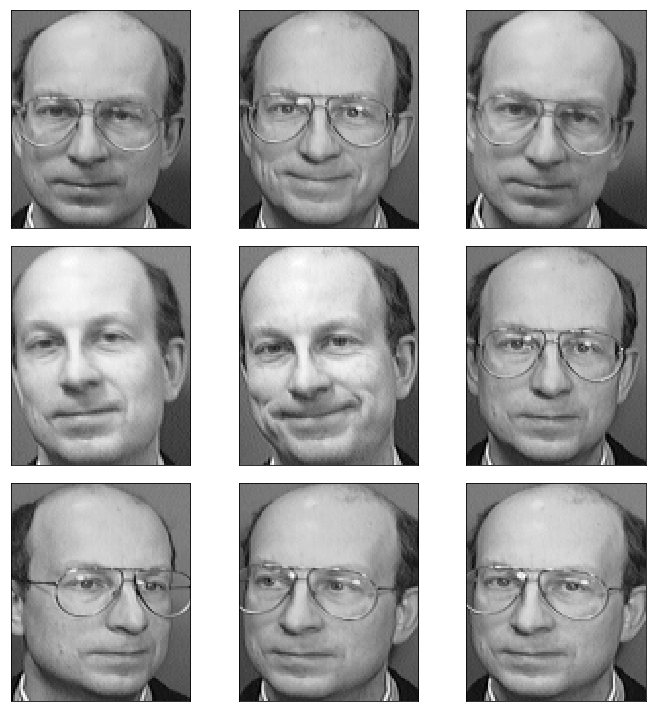

In [9]:
subject_idx = 4
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),
      (ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,10))
subject_img_idx = np.where(Y_train==subject_idx)[0].tolist()

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

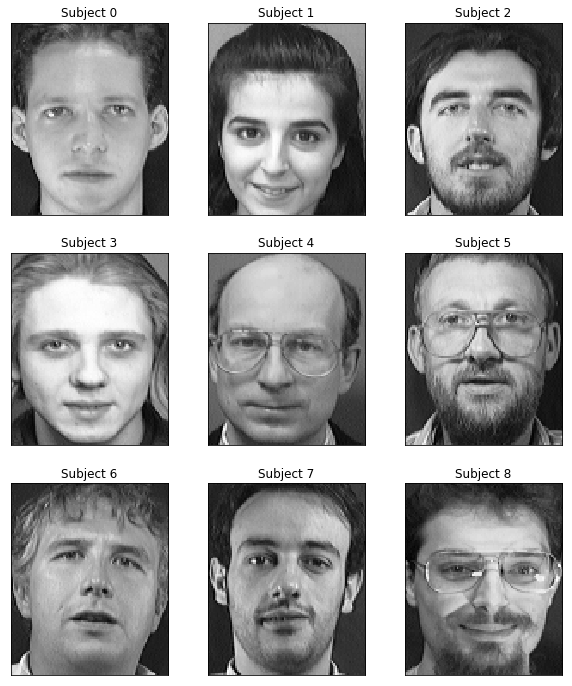

<Figure size 432x288 with 0 Axes>

In [10]:
# Plot the first 9 subjects
subjects = range(10)

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),
      (ax7,ax8,ax9)) = plt.subplots(3,3,figsize=(10,12))
subject_img_idx = [np.where(Y_train==i)[0].tolist()[0] for i in subjects]

for i, ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    img = X_train[subject_img_idx[i]]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("Subject {}".format(i))
plt.show()
plt.tight_layout()

In [16]:
def create_shared_network(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', 
                     input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=128, activation='sigmoid'))
    return model

In [17]:
def euclidean_distance(vectors):
    vector1, vector2 = vectors
    sum_square = K.sum(K.square(vector1 - vector2), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def contrastive_loss(Y_true, D):
    margin = 1
    return K.mean(Y_true*K.square(D)+(1 - Y_true)*K.maximum((margin-D),0))

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [18]:
def create_pairs(X,Y, num_classes):
    pairs, labels = [], []
    # index of images in X and Y for each class
    class_idx = [np.where(Y==i)[0] for i in range(num_classes)]
    # The minimum number of images across all classes
    min_images = min(len(class_idx[i]) for i in range(num_classes)) - 1

    for c in range(num_classes):
        for n in range(min_images):
            # create positive pair
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[c][n+1]]
            pairs.append((img1, img2))
            labels.append(1)

            # create negative pair
            neg_list = list(range(num_classes))
            neg_list.remove(c)
            # select a random class from the negative list. 
            # this class will be used to form the negative pair
            neg_c = random.sample(neg_list,1)[0]
            img1 = X[class_idx[c][n]]
            img2 = X[class_idx[neg_c][n]]
            pairs.append((img1,img2))
            labels.append(0)

    return np.array(pairs), np.array(labels)

In [19]:
def write_on_frame(frame, text, text_x, text_y):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=2)[0]
    box_coords = ((text_x, text_y), (text_x+text_width+20, text_y-text_height-20))
    cv2.rectangle(frame, box_coords[0], box_coords[1], (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, text, (text_x, text_y-10), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0), thickness=2)
    return frame

In [14]:
#(X_train, Y_train), (X_test, Y_test) = get_data(faces_dir)
num_classes = len(np.unique(Y_train))

# Create Siamese Neural Network
input_shape = X_train.shape[1:]
shared_network = create_shared_network(input_shape)
input_top = Input(shape=input_shape)
input_bottom = Input(shape=input_shape)
output_top = shared_network(input_top)
output_bottom = shared_network(input_bottom)
distance = Lambda(euclidean_distance, output_shape=(1,))([output_top, output_bottom])
model = Model(inputs=[input_top, input_bottom], outputs=distance)
print(model.summary())

# Train the model
training_pairs, training_labels = create_pairs(X_train, Y_train, num_classes=num_classes)

model.compile(loss=contrastive_loss, optimizer='Adam',metrics=[accuracy])

model.fit([training_pairs[:, 0], training_pairs[:, 1]], training_labels,
          batch_size=64,
          epochs=5)

# Save the model
model.save('./models/siamese_nn.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 112, 92, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 128)          18744768    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]               
          

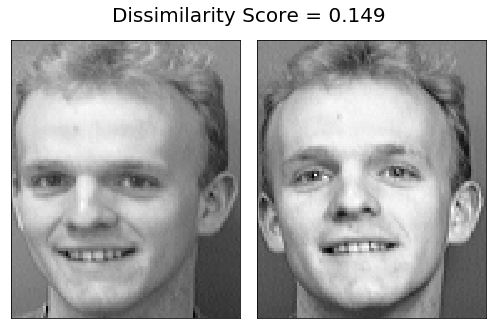

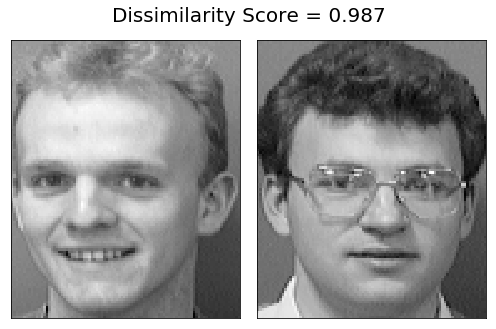

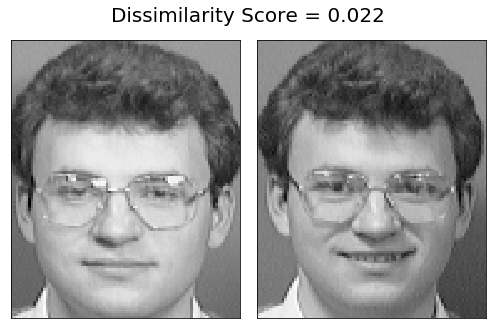

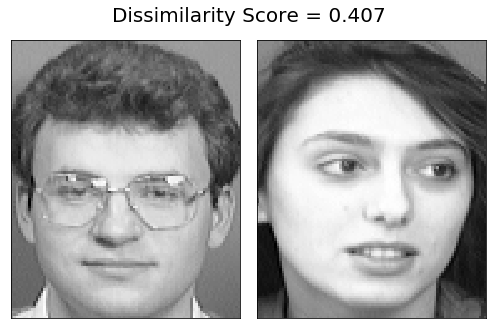

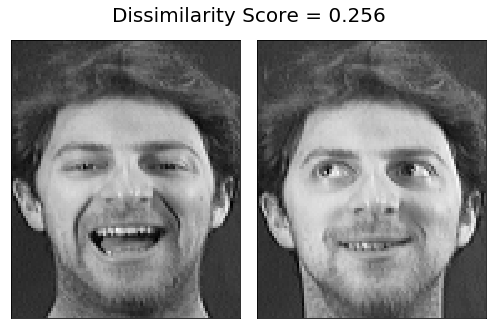

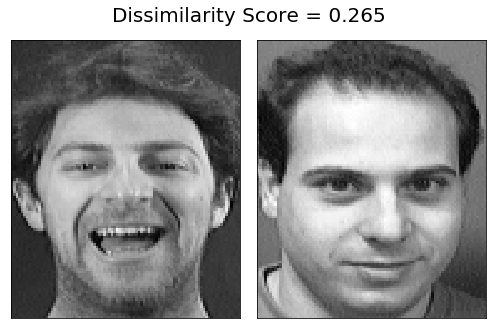

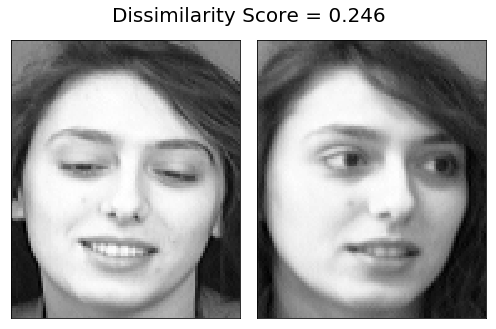

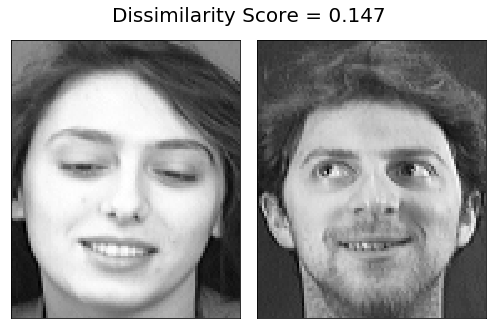

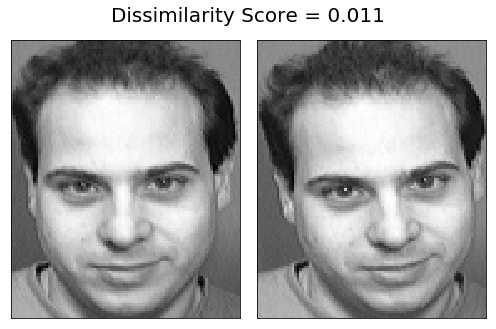

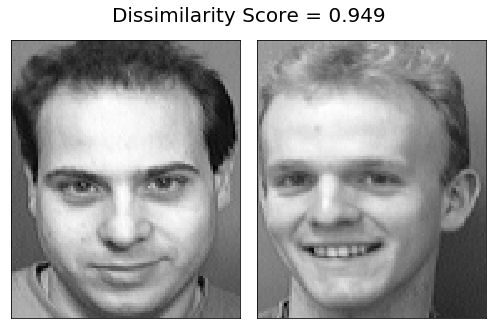

In [16]:
test_pairs, test_labels = create_pairs(X_test, Y_test, len(np.unique(Y_test)))

for i in range(5):
    for n in range(0,2):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7,5))
        img1 = np.expand_dims(test_pairs[i*20+n, 0], axis=0)
        img2 = np.expand_dims(test_pairs[i*20+n, 1], axis=0)
        dissimilarity = model.predict([img1, img2])[0][0]
        img1, img2 = np.squeeze(img1), np.squeeze(img2)
        ax1.imshow(img1, cmap='gray')
        ax2.imshow(img2, cmap='gray')

        for ax in [ax1, ax2]:
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        fig.suptitle("Dissimilarity Score = {:.3f}".format(dissimilarity), 
                      size=20)
plt.show()

#### Creating a real-time face recognition program

In [17]:
video_capture = cv2.VideoCapture(0)

In [23]:
model = load_model('./models/siamese_nn.h5', 
                    custom_objects={'contrastive_loss': contrastive_loss, 
                    'euclidean_distance': euclidean_distance})

In [10]:
#faceCascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

video_capture = cv2.VideoCapture(0)

img_counter = 0

while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    
    detected_faces, _, _ = detect_faces(frame)
    
    cv2.imshow("test", frame)

  #  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #cv2.imwrite("./outputimage.jpg", frame) 
    
    k = cv2.waitKey(1)

    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = './opencv_frame_{}.png'.format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
            
video_capture.release()
cv2.destroyAllWindows()

./opencv_frame_0.png written!
Escape hit, closing...


In [6]:
video_capture.release()
cv2.destroyAllWindows()

In [13]:
name = input("What is your name?")

What is your name?Himanshu


In [14]:
name

'Himanshu'

In [11]:
true_img = cv2.imread('./opencv_frame_0.png', 0)
true_img = true_img.astype('float32')/255
true_img = cv2.resize(true_img, (92, 112))
true_img = true_img.reshape(1, true_img.shape[0], true_img.shape[1], 1)

In [25]:
video_capture = cv2.VideoCapture(0)
preds = collections.deque(maxlen=15)

while True:
    # Capture frame-by-frame
    _, frame = video_capture.read()

    # Detect Faces
    frame, face_img, face_coords = detect_faces(frame)

    if face_img is not None:
        face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
        face_img = face_img.astype('float32')/255
        face_img = cv2.resize(face_img, (92, 112))
        face_img = face_img.reshape(1, face_img.shape[0], 
                   face_img.shape[1], 1)
        preds.append(1-model.predict([true_img, face_img])[0][0])
        x,y,w,h = face_coords
        if len(preds) == 15 and sum(preds)/15 >= 0.3:
            text = "Identity: {}".format(name)
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5) 
        elif len(preds) < 15:
            text = "Identifying ..."
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 165, 255), 5) 
        else:
            text = "Identity Unknown!"
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 5)
        frame = write_on_frame(frame, text, face_coords[0], 
                                     face_coords[1]-10)
    else:
        # clear existing predictions if no face detected 
        preds = collections.deque(maxlen=15) 

    # Display the resulting frame
    cv2.imshow('Video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()